<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_0129_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Prep

In [2]:
%cd /content/gdrive/MyDrive/Kaggle/unzip/
!cp ../kaggle.json /root/.kaggle/

/content/gdrive/MyDrive/Kaggle/unzip


GitHub

In [3]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.

import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader #For working with data.

from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(3407)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [5]:
path = "/content/gdrive/MyDrive/Kaggle/unzip/"

all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split

# subset
sub_df, depre_df = train_test_split(all_df, test_size=0.8, random_state=42)

# Assuming train_df is your original training DataFrame
train_df, test_df = train_test_split(sub_df, test_size=1400, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)


print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


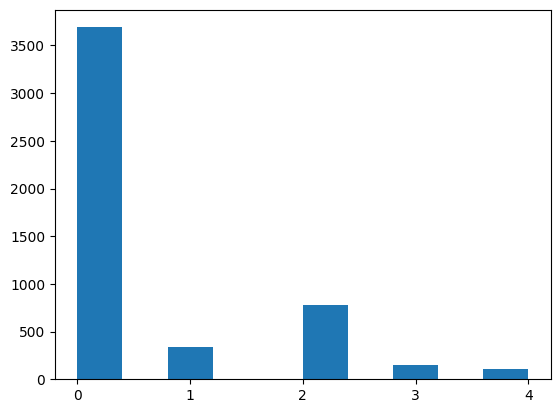

In [6]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [7]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [8]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [9]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [10]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [11]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4) #DataLoader for validation_set.
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [12]:
from torchvision.models import resnet50,ResNet50_Weights
#Since we've less data, we'll use Transfer learning.
model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50 with 2 new layers.
model.fc = nn.Sequential(
    nn.Linear(2048, 5),
)

In [13]:
model = model.to(device) #Moves the model to the device.

In [14]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.

        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        # x, y = x.cpu(), y.cpu()
        torch.cuda.empty_cache()

        # Print some information every 10 batches
        if batch % 10 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, './DR_ResNet50.pt')
    return avg_loss, accuracy

In [15]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [16]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')



        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Change 5: Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')
            break


        # Step the learning rate scheduler
        scheduler.step()
        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses

In [17]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005)
nb_epochs = 30
patience = 4
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)


Epoch 1/30
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.653175, correct predictions: 2, total: 16
Batch 10/317 processed, running loss: 17.536213, correct predictions: 24, total: 176
Batch 20/317 processed, running loss: 33.087919, correct predictions: 47, total: 336
Batch 30/317 processed, running loss: 47.898250, correct predictions: 77, total: 496
Batch 40/317 processed, running loss: 63.777148, correct predictions: 126, total: 656
Batch 50/317 processed, running loss: 80.358757, correct predictions: 198, total: 816
Batch 60/317 processed, running loss: 96.518895, correct predictions: 281, total: 976
Batch 70/317 processed, running loss: 112.812725, correct predictions: 332, total: 1136
Batch 80/317 processed, running loss: 128.457486, correct predictions: 371, total: 1296
Batch 90/317 processed, running loss: 144.098414, correct predictions: 434, total: 1456
Batch 100/317 processed, running loss: 158.499483, correct pred

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.458285, correct predictions: 7, total: 16
Batch 10/317 processed, running loss: 15.870673, correct predictions: 99, total: 176
Batch 20/317 processed, running loss: 29.371705, correct predictions: 185, total: 336
Batch 30/317 processed, running loss: 42.695684, correct predictions: 288, total: 496
Batch 40/317 processed, running loss: 57.633296, correct predictions: 404, total: 656
Batch 50/317 processed, running loss: 72.367687, correct predictions: 505, total: 816
Batch 60/317 processed, running loss: 86.800993, correct predictions: 606, total: 976
Batch 70/317 processed, running loss: 100.531054, correct predictions: 713, total: 1136
Batch 80/317 processed, running loss: 114.537930, correct predictions: 815, total: 1296
Batch 90/317 processed, running loss: 127.939929, correct predictions: 924, total: 1456
Batch 100/317 processed, running loss: 142.414940, correct predictions: 1017, total: 1616
Batch 110/317 processed, running loss: 156.165756,

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.138419, correct predictions: 6, total: 16
Batch 10/317 processed, running loss: 11.701462, correct predictions: 95, total: 176
Batch 20/317 processed, running loss: 22.968112, correct predictions: 198, total: 336
Batch 30/317 processed, running loss: 33.392782, correct predictions: 292, total: 496
Batch 40/317 processed, running loss: 43.854609, correct predictions: 397, total: 656
Batch 50/317 processed, running loss: 56.334195, correct predictions: 516, total: 816
Batch 60/317 processed, running loss: 69.501661, correct predictions: 622, total: 976
Batch 70/317 processed, running loss: 81.844351, correct predictions: 722, total: 1136
Batch 80/317 processed, running loss: 95.266005, correct predictions: 795, total: 1296
Batch 90/317 processed, running loss: 105.819633, correct predictions: 889, total: 1456
Batch 100/317 processed, running loss: 117.654137, correct predictions: 977, total: 1616
Batch 110/317 processed, running loss: 127.768571, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.159321, correct predictions: 12, total: 16
Batch 10/317 processed, running loss: 11.240977, correct predictions: 116, total: 176
Batch 20/317 processed, running loss: 22.730172, correct predictions: 201, total: 336
Batch 30/317 processed, running loss: 33.779232, correct predictions: 296, total: 496
Batch 40/317 processed, running loss: 43.397757, correct predictions: 401, total: 656
Batch 50/317 processed, running loss: 57.062772, correct predictions: 488, total: 816
Batch 60/317 processed, running loss: 66.683639, correct predictions: 608, total: 976
Batch 70/317 processed, running loss: 77.153212, correct predictions: 715, total: 1136
Batch 80/317 processed, running loss: 89.902571, correct predictions: 805, total: 1296
Batch 90/317 processed, running loss: 102.062816, correct predictions: 902, total: 1456
Batch 100/317 processed, running loss: 114.068760, correct predictions: 979, total: 1616
Batch 110/317 processed, running loss: 124.275646, 

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.096126, correct predictions: 11, total: 16
Batch 10/317 processed, running loss: 10.731792, correct predictions: 129, total: 176
Batch 20/317 processed, running loss: 20.067113, correct predictions: 253, total: 336
Batch 30/317 processed, running loss: 29.861064, correct predictions: 358, total: 496
Batch 40/317 processed, running loss: 39.048565, correct predictions: 479, total: 656
Batch 50/317 processed, running loss: 49.424489, correct predictions: 597, total: 816
Batch 60/317 processed, running loss: 58.012194, correct predictions: 714, total: 976
Batch 70/317 processed, running loss: 67.986476, correct predictions: 813, total: 1136
Batch 80/317 processed, running loss: 77.256315, correct predictions: 896, total: 1296
Batch 90/317 processed, running loss: 87.016682, correct predictions: 971, total: 1456
Batch 100/317 processed, running loss: 96.730724, correct predictions: 1067, total: 1616
Batch 110/317 processed, running loss: 106.802006, c

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.668259, correct predictions: 10, total: 16
Batch 10/317 processed, running loss: 10.257778, correct predictions: 104, total: 176
Batch 20/317 processed, running loss: 22.073224, correct predictions: 206, total: 336
Batch 30/317 processed, running loss: 30.578822, correct predictions: 302, total: 496
Batch 40/317 processed, running loss: 38.784549, correct predictions: 418, total: 656
Batch 50/317 processed, running loss: 48.250091, correct predictions: 538, total: 816
Batch 60/317 processed, running loss: 57.327318, correct predictions: 640, total: 976
Batch 70/317 processed, running loss: 65.675317, correct predictions: 731, total: 1136
Batch 80/317 processed, running loss: 73.625316, correct predictions: 844, total: 1296
Batch 90/317 processed, running loss: 81.939067, correct predictions: 951, total: 1456
Batch 100/317 processed, running loss: 90.163284, correct predictions: 1059, total: 1616
Batch 110/317 processed, running loss: 98.168192, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.884307, correct predictions: 10, total: 16
Batch 10/317 processed, running loss: 8.095816, correct predictions: 111, total: 176
Batch 20/317 processed, running loss: 16.170110, correct predictions: 211, total: 336
Batch 30/317 processed, running loss: 24.316319, correct predictions: 319, total: 496
Batch 40/317 processed, running loss: 32.516294, correct predictions: 419, total: 656
Batch 50/317 processed, running loss: 40.325055, correct predictions: 536, total: 816
Batch 60/317 processed, running loss: 47.249057, correct predictions: 644, total: 976
Batch 70/317 processed, running loss: 55.488066, correct predictions: 760, total: 1136
Batch 80/317 processed, running loss: 65.127317, correct predictions: 874, total: 1296
Batch 90/317 processed, running loss: 74.928987, correct predictions: 982, total: 1456
Batch 100/317 processed, running loss: 82.292369, correct predictions: 1089, total: 1616
Batch 110/317 processed, running loss: 89.826161, cor

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.366864, correct predictions: 16, total: 16
Batch 10/317 processed, running loss: 7.982557, correct predictions: 129, total: 176
Batch 20/317 processed, running loss: 15.855473, correct predictions: 244, total: 336
Batch 30/317 processed, running loss: 21.886430, correct predictions: 354, total: 496
Batch 40/317 processed, running loss: 30.548176, correct predictions: 465, total: 656
Batch 50/317 processed, running loss: 38.292686, correct predictions: 576, total: 816
Batch 60/317 processed, running loss: 45.569128, correct predictions: 686, total: 976
Batch 70/317 processed, running loss: 52.801581, correct predictions: 791, total: 1136
Batch 80/317 processed, running loss: 60.706468, correct predictions: 888, total: 1296
Batch 90/317 processed, running loss: 67.804854, correct predictions: 991, total: 1456
Batch 100/317 processed, running loss: 75.140391, correct predictions: 1115, total: 1616
Batch 110/317 processed, running loss: 81.994740, cor

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.440523, correct predictions: 12, total: 16
Batch 10/317 processed, running loss: 8.378478, correct predictions: 132, total: 176
Batch 20/317 processed, running loss: 16.635940, correct predictions: 251, total: 336
Batch 30/317 processed, running loss: 24.472936, correct predictions: 369, total: 496
Batch 40/317 processed, running loss: 30.130442, correct predictions: 492, total: 656
Batch 50/317 processed, running loss: 36.739494, correct predictions: 610, total: 816
Batch 60/317 processed, running loss: 44.227235, correct predictions: 739, total: 976
Batch 70/317 processed, running loss: 50.119220, correct predictions: 865, total: 1136
Batch 80/317 processed, running loss: 57.228194, correct predictions: 981, total: 1296
Batch 90/317 processed, running loss: 63.973342, correct predictions: 1108, total: 1456
Batch 100/317 processed, running loss: 71.574470, correct predictions: 1221, total: 1616
Batch 110/317 processed, running loss: 77.921774, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.281973, correct predictions: 15, total: 16
Batch 10/317 processed, running loss: 5.987103, correct predictions: 146, total: 176
Batch 20/317 processed, running loss: 12.503281, correct predictions: 275, total: 336
Batch 30/317 processed, running loss: 19.228552, correct predictions: 391, total: 496
Batch 40/317 processed, running loss: 24.833413, correct predictions: 514, total: 656
Batch 50/317 processed, running loss: 30.838783, correct predictions: 635, total: 816
Batch 60/317 processed, running loss: 37.015245, correct predictions: 751, total: 976
Batch 70/317 processed, running loss: 42.672630, correct predictions: 876, total: 1136
Batch 80/317 processed, running loss: 48.295395, correct predictions: 1001, total: 1296
Batch 90/317 processed, running loss: 55.711838, correct predictions: 1120, total: 1456
Batch 100/317 processed, running loss: 61.594987, correct predictions: 1249, total: 1616
Batch 110/317 processed, running loss: 67.815647, c

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.326890, correct predictions: 14, total: 16
Batch 10/317 processed, running loss: 5.071904, correct predictions: 136, total: 176
Batch 20/317 processed, running loss: 10.685696, correct predictions: 262, total: 336
Batch 30/317 processed, running loss: 16.795265, correct predictions: 378, total: 496
Batch 40/317 processed, running loss: 22.020424, correct predictions: 491, total: 656
Batch 50/317 processed, running loss: 26.429488, correct predictions: 614, total: 816
Batch 60/317 processed, running loss: 32.772179, correct predictions: 732, total: 976
Batch 70/317 processed, running loss: 42.152377, correct predictions: 845, total: 1136
Batch 80/317 processed, running loss: 48.754052, correct predictions: 954, total: 1296
Batch 90/317 processed, running loss: 54.949025, correct predictions: 1074, total: 1456
Batch 100/317 processed, running loss: 61.687034, correct predictions: 1205, total: 1616
Batch 110/317 processed, running loss: 67.333325, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.338427, correct predictions: 15, total: 16
Batch 10/317 processed, running loss: 6.234833, correct predictions: 129, total: 176
Batch 20/317 processed, running loss: 11.304512, correct predictions: 249, total: 336
Batch 30/317 processed, running loss: 16.637125, correct predictions: 368, total: 496
Batch 40/317 processed, running loss: 22.474662, correct predictions: 493, total: 656
Batch 50/317 processed, running loss: 28.850136, correct predictions: 614, total: 816
Batch 60/317 processed, running loss: 33.588104, correct predictions: 754, total: 976
Batch 70/317 processed, running loss: 39.763991, correct predictions: 880, total: 1136
Batch 80/317 processed, running loss: 45.534149, correct predictions: 1004, total: 1296
Batch 90/317 processed, running loss: 50.948426, correct predictions: 1129, total: 1456
Batch 100/317 processed, running loss: 57.198277, correct predictions: 1256, total: 1616
Batch 110/317 processed, running loss: 62.038848, c

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.304322, correct predictions: 14, total: 16
Batch 10/317 processed, running loss: 5.208061, correct predictions: 141, total: 176
Batch 20/317 processed, running loss: 9.432790, correct predictions: 270, total: 336
Batch 30/317 processed, running loss: 14.976892, correct predictions: 395, total: 496
Batch 40/317 processed, running loss: 20.082021, correct predictions: 529, total: 656
Batch 50/317 processed, running loss: 25.114211, correct predictions: 652, total: 816
Batch 60/317 processed, running loss: 30.482536, correct predictions: 781, total: 976
Batch 70/317 processed, running loss: 35.856019, correct predictions: 912, total: 1136
Batch 80/317 processed, running loss: 40.050093, correct predictions: 1041, total: 1296
Batch 90/317 processed, running loss: 44.220479, correct predictions: 1170, total: 1456
Batch 100/317 processed, running loss: 48.381084, correct predictions: 1294, total: 1616
Batch 110/317 processed, running loss: 53.576327, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.410818, correct predictions: 14, total: 16
Batch 10/317 processed, running loss: 4.744051, correct predictions: 150, total: 176
Batch 20/317 processed, running loss: 9.674851, correct predictions: 282, total: 336
Batch 30/317 processed, running loss: 14.341226, correct predictions: 405, total: 496
Batch 40/317 processed, running loss: 18.542397, correct predictions: 539, total: 656
Batch 50/317 processed, running loss: 22.893195, correct predictions: 672, total: 816
Batch 60/317 processed, running loss: 27.052510, correct predictions: 804, total: 976
Batch 70/317 processed, running loss: 32.005253, correct predictions: 928, total: 1136
Batch 80/317 processed, running loss: 36.901894, correct predictions: 1046, total: 1296
Batch 90/317 processed, running loss: 40.869323, correct predictions: 1169, total: 1456
Batch 100/317 processed, running loss: 45.892442, correct predictions: 1295, total: 1616
Batch 110/317 processed, running loss: 51.188675, co

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.229932, correct predictions: 12, total: 16
Batch 10/317 processed, running loss: 6.115769, correct predictions: 129, total: 176
Batch 20/317 processed, running loss: 10.673054, correct predictions: 262, total: 336
Batch 30/317 processed, running loss: 15.104730, correct predictions: 382, total: 496
Batch 40/317 processed, running loss: 18.769961, correct predictions: 519, total: 656
Batch 50/317 processed, running loss: 24.124777, correct predictions: 640, total: 816
Batch 60/317 processed, running loss: 28.603211, correct predictions: 766, total: 976
Batch 70/317 processed, running loss: 34.080052, correct predictions: 895, total: 1136
Batch 80/317 processed, running loss: 40.523862, correct predictions: 1013, total: 1296
Batch 90/317 processed, running loss: 45.075308, correct predictions: 1131, total: 1456
Batch 100/317 processed, running loss: 49.361779, correct predictions: 1257, total: 1616
Batch 110/317 processed, running loss: 53.920159, c

<ipython-input-16-473e11fd7032>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.599872, correct predictions: 12, total: 16
Batch 10/317 processed, running loss: 4.658945, correct predictions: 142, total: 176
Batch 20/317 processed, running loss: 8.912083, correct predictions: 266, total: 336
Batch 30/317 processed, running loss: 12.789699, correct predictions: 397, total: 496
Batch 40/317 processed, running loss: 18.336751, correct predictions: 519, total: 656
Batch 50/317 processed, running loss: 22.883664, correct predictions: 643, total: 816
Batch 60/317 processed, running loss: 27.293884, correct predictions: 780, total: 976
Batch 70/317 processed, running loss: 32.369691, correct predictions: 909, total: 1136
Batch 80/317 processed, running loss: 37.267414, correct predictions: 1043, total: 1296
Batch 90/317 processed, running loss: 40.810013, correct predictions: 1180, total: 1456
Batch 100/317 processed, running loss: 45.107441, correct predictions: 1309, total: 1616
Batch 110/317 processed, running loss: 49.082234, co

In [18]:
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


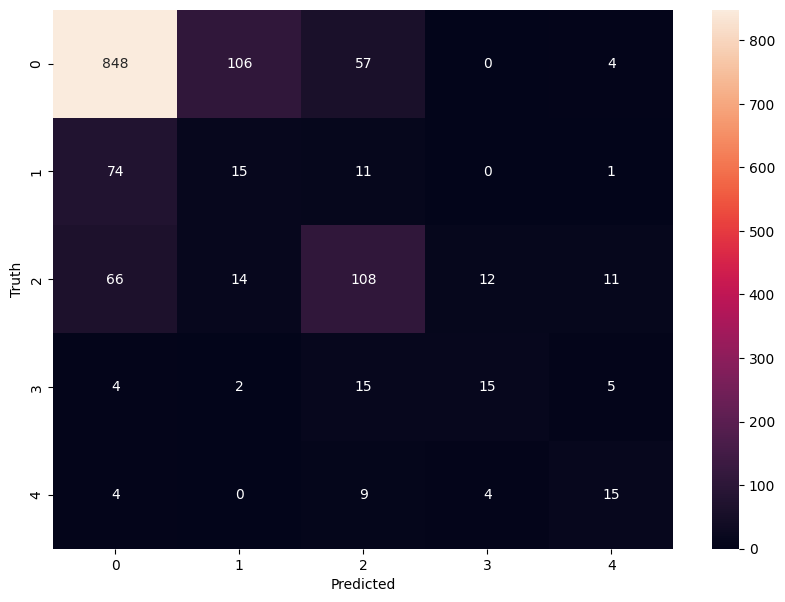

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1015
           1       0.11      0.15      0.13       101
           2       0.54      0.51      0.53       211
           3       0.48      0.37      0.42        41
           4       0.42      0.47      0.44        32

    accuracy                           0.71      1400
   macro avg       0.48      0.47      0.47      1400
weighted avg       0.73      0.71      0.72      1400

For class 0, Sensitivity: 0.8354679802955665, Specificity: 0.6155844155844156
For class 1, Sensitivity: 0.1485148514851485, Specificity: 0.9060816012317167
For class 2, Sensitivity: 0.5118483412322274, Specificity: 0.9226240538267452
For class 3, Sensitivity: 0.36585365853658536, Specificity: 0.9882266372332598
For class 4, Sensitivity: 0.46875, Specificity: 0.9846491228070176


In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")
